# Notebook 02: Data Analysis and Plotting for C. elegans Motility

This notebook handles:
- Loading processed data from Notebook 01
- Statistical analysis (mean, SEM, statistical tests)
- Visualization of:
  - Mean speed comparisons by genotype
  - XY track plots (all tracks normalized to origin)
  - Movement metrics (straightness index, fatigue)
  - Thrashing frequency comparisons
- Saving publication-quality figures and statistical results

## 1. Import Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal
from scipy.signal import find_peaks
import json
import warnings
import yaml
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Configuration and Path Setup

In [57]:
# Base paths
BASE_DIR = Path(r'C:\Users\MBF\Motility_analysis')
PROCESSED_DATA_DIR = BASE_DIR / 'Data' / 'Processed'
RESULTS_DIR = BASE_DIR / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'

# Create output directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Processed data directory: {PROCESSED_DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

Processed data directory: C:\Users\MBF\Motility_analysis\Data\Processed
Results directory: C:\Users\MBF\Motility_analysis\results
Figures directory: C:\Users\MBF\Motility_analysis\results\figures


## 3. Load Processed Data

In [58]:
# Load processed data from Notebook 01
df_metrics = pd.read_csv(PROCESSED_DATA_DIR / 'track_metrics.csv')
df_thrashing = pd.read_csv(PROCESSED_DATA_DIR / 'thrashing_data.csv')
df_tracks = pd.read_csv(PROCESSED_DATA_DIR / 'normalized_tracks.csv')

print("Data loaded successfully!")
print(f"\nMetrics data: {df_metrics.shape}")
print(f"Thrashing data: {df_thrashing.shape}")
print(f"Track coordinates: {df_tracks.shape}")

Data loaded successfully!

Metrics data: (64, 13)
Thrashing data: (64, 7)
Track coordinates: (19238, 7)


In [60]:
# Build strain/genotype labels from YAML metadata
RAW_DATA_DIR = BASE_DIR / 'Data' / 'Raw'
metadata_rows = []
for yaml_path in RAW_DATA_DIR.glob('**/Wormlab_processed/*/metadata_*.yaml'):
    with open(yaml_path, 'r') as f:
        meta = yaml.safe_load(f) or {}
    genotype_dir = yaml_path.parent.name
    metadata_rows.append({
        'genotype_dir': genotype_dir,
        'strain': meta.get('strain', genotype_dir),
        'genotype_yaml': meta.get('genotype', genotype_dir),
        'auxin_mM': meta.get('auxin_mM', None),
    })

metadata_df = pd.DataFrame(metadata_rows)
if metadata_df.empty or 'genotype_dir' not in metadata_df.columns:
    metadata_df = pd.DataFrame(columns=['genotype_dir', 'strain', 'genotype_yaml', 'auxin_mM'])
else:
    metadata_df = metadata_df.drop_duplicates('genotype_dir')

desired_order_dirs = ['N2', 'RK202', 'RK204', 'RK203', 'RK205']

def format_auxin(value):
    if pd.isna(value):
        return 'auxin N/A'
    try:
        return f"auxin {float(value):g} mM"
    except Exception:
        return f"auxin {str(value)}"

def add_labels(df):
    # Remove prior merge columns to avoid duplicate suffix collisions on re-run
    drop_cols = [
        'genotype_dir',
        'strain', 'strain_data', 'strain_meta',
        'genotype_yaml', 'genotype_yaml_data', 'genotype_yaml_meta',
        'auxin_mM', 'auxin_mM_data', 'auxin_mM_meta',
        'strain_genotype'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    if metadata_df.empty or 'genotype_dir' not in metadata_df.columns:
        df['strain_genotype'] = df['genotype'].astype(str)
        return df
    df = df.merge(
        metadata_df,
        left_on='genotype',
        right_on='genotype_dir',
        how='left',
        suffixes=('_data', '_meta')
    )
    if 'strain_meta' in df.columns:
        strain = df['strain_meta']
    elif 'strain_data' in df.columns:
        strain = df['strain_data']
    else:
        strain = df['strain']
    strain = strain.fillna(df['genotype']).astype(str)
    if 'genotype_yaml_meta' in df.columns:
        genotype_yaml = df['genotype_yaml_meta']
    elif 'genotype_yaml_data' in df.columns:
        genotype_yaml = df['genotype_yaml_data']
    else:
        genotype_yaml = df['genotype_yaml']
    genotype_yaml = genotype_yaml.fillna(df['genotype']).astype(str)
    if 'auxin_mM_meta' in df.columns:
        auxin = df['auxin_mM_meta']
    elif 'auxin_mM_data' in df.columns:
        auxin = df['auxin_mM_data']
    else:
        auxin = df['auxin_mM']
    auxin_label = auxin.apply(format_auxin)
    # Append treatment to parent folder name (df['genotype'])
    folder_label = df['genotype'].astype(str) + ' (' + auxin_label + ')'
    df['strain_genotype'] = strain + ' (' + genotype_yaml + ', ' + folder_label + ')'
    return df

df_metrics = add_labels(df_metrics)
df_thrashing = add_labels(df_thrashing)
df_tracks = add_labels(df_tracks)

labels_by_genotype = df_metrics[['genotype', 'strain_genotype']].drop_duplicates()
label_by_genotype = labels_by_genotype.set_index('genotype')['strain_genotype'].astype(str).to_dict()
order_labels = []
for genotype_dir in desired_order_dirs:
    match = labels_by_genotype[labels_by_genotype['genotype'] == genotype_dir]
    if not match.empty:
        order_labels.append(str(match['strain_genotype'].iloc[0]))

remaining = labels_by_genotype[~labels_by_genotype['genotype'].isin(desired_order_dirs)]
order_labels.extend(sorted(remaining['strain_genotype'].astype(str).unique()))

def apply_order(df, order_labels):
    if order_labels:
        df['strain_genotype'] = pd.Categorical(
            df['strain_genotype'],
            categories=order_labels,
            ordered=True
        )
    return df

df_metrics = apply_order(df_metrics, order_labels)
df_thrashing = apply_order(df_thrashing, order_labels)
df_tracks = apply_order(df_tracks, order_labels)

if order_labels:
    unique_labels = df_metrics['strain_genotype'].astype(str).unique()
    genotypes = [label for label in order_labels if label in unique_labels]
else:
    genotypes = sorted(df_metrics['strain_genotype'].astype(str).unique())
print("\nStrain/Genotype groups:")
for g in genotypes:
    n_tracks = len(df_metrics[df_metrics['strain_genotype'].astype(str) == g])
    print(f"  {g}: {n_tracks} tracks")


Strain/Genotype groups:
  OGxxxx_1mMaux: 29 tracks
  OGxxxx_noaux: 35 tracks


## 4. Statistical Analysis Functions

In [61]:
def calculate_group_stats(df, group_col, value_col):
    """
    Calculate mean, SEM, and sample size for each group
    """
    stats_df = df.groupby(group_col, sort=False)[value_col].agg([
        ('mean', 'mean'),
        ('std', 'std'),
        ('n', 'count')
    ]).reset_index()
    
    if pd.api.types.is_categorical_dtype(stats_df[group_col]):
        stats_df = stats_df.sort_values(group_col).reset_index(drop=True)
    
    # Calculate SEM
    stats_df['sem'] = stats_df['std'] / np.sqrt(stats_df['n'])
    
    return stats_df


def perform_anova(df, group_col, value_col):
    """
    Perform one-way ANOVA across groups
    """
    groups = df[group_col].unique()
    group_data = [df[df[group_col] == g][value_col].dropna() for g in groups]
    
    # Remove empty groups
    group_data = [g for g in group_data if len(g) > 0]
    
    if len(group_data) < 2:
        return None, None
    
    f_stat, p_value = f_oneway(*group_data)
    
    return f_stat, p_value


def perform_pairwise_tests(df, group_col, value_col, test='ttest'):
    """
    Perform pairwise statistical tests between all groups
    test: 'ttest' or 'mannwhitney'
    """
    groups = sorted(df[group_col].unique())
    results = []
    
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            
            data1 = df[df[group_col] == group1][value_col].dropna()
            data2 = df[df[group_col] == group2][value_col].dropna()
            
            if len(data1) > 0 and len(data2) > 0:
                if test == 'ttest':
                    stat, p_value = ttest_ind(data1, data2)
                    test_name = 't-test'
                else:
                    stat, p_value = mannwhitneyu(data1, data2)
                    test_name = 'Mann-Whitney U'
                
                results.append({
                    'group1': group1,
                    'group2': group2,
                    'test': test_name,
                    'statistic': stat,
                    'p_value': p_value,
                    'significant': 'Yes' if p_value < 0.05 else 'No',
                })
    
    return pd.DataFrame(results)


print("Statistical functions defined successfully!")

Statistical functions defined successfully!


## 5. Analysis 1: Mean Speed Comparison

In [62]:
# Calculate group statistics for speed
speed_stats = calculate_group_stats(df_metrics, 'strain_genotype', 'mean_speed')
print("=== Mean Speed by Strain/Genotype ===")
print(speed_stats)

# Perform ANOVA
f_stat, p_value = perform_anova(df_metrics, 'strain_genotype', 'mean_speed')
print(f"\nOne-way ANOVA: F={f_stat:.4f}, p={p_value:.4e}")

# Pairwise comparisons
pairwise_speed = perform_pairwise_tests(df_metrics, 'strain_genotype', 'mean_speed', test='ttest')
print("\n=== Pairwise Comparisons (Speed) ===")
print(pairwise_speed)

# Save results
speed_stats.to_csv(RESULTS_DIR / 'speed_group_summary.csv', index=False)
pairwise_speed.to_csv(RESULTS_DIR / 'speed_pairwise_tests.csv', index=False)

=== Mean Speed by Strain/Genotype ===
  strain_genotype        mean         std   n        sem
0   OGxxxx_1mMaux  484.884694   76.658417  29  14.235111
1    OGxxxx_noaux  467.974075  129.228456  35  21.843596

One-way ANOVA: F=0.3840, p=5.3776e-01

=== Pairwise Comparisons (Speed) ===
          group1        group2    test  statistic   p_value significant
0  OGxxxx_1mMaux  OGxxxx_noaux  t-test   0.619643  0.537764          No


## 6. Plot 1: Mean Speed Bar Plot

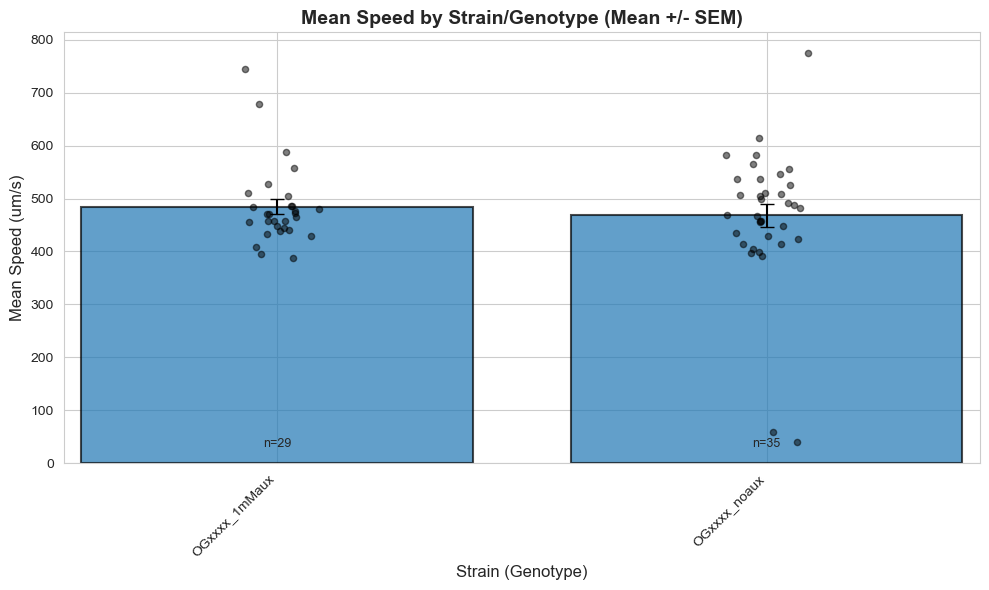

Speed comparison plot saved!


In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with error bars
x_pos = np.arange(len(speed_stats))
ax.bar(x_pos, speed_stats['mean'], yerr=speed_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5)

# Overlay individual points
for i, label in enumerate(speed_stats['strain_genotype']):
    data = df_metrics[df_metrics['strain_genotype'] == label]['mean_speed'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.5, color='black', s=20)

ax.set_xticks(x_pos)
ax.set_xticklabels(speed_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Mean Speed (um/s)', fontsize=12)
ax.set_xlabel('Strain (Genotype)', fontsize=12)
ax.set_title('Mean Speed by Strain/Genotype (Mean +/- SEM)', fontsize=14, fontweight='bold')
ax.margins(x=0.02)
ax.set_ylim(bottom=0)

# Add sample sizes inside plot area
y_min, y_max = ax.get_ylim()
y_text = y_min + 0.03 * (y_max - y_min)
for i, (label, n) in enumerate(zip(speed_stats['strain_genotype'], speed_stats['n'])):
    ax.text(i, y_text, f'n={int(n)}', ha='center', va='bottom', fontsize=9)

# Add p-value annotations for specific comparisons
label_to_x = {str(label): idx for idx, label in enumerate(speed_stats['strain_genotype'])}
pairwise_speed['group1'] = pairwise_speed['group1'].astype(str)
pairwise_speed['group2'] = pairwise_speed['group2'].astype(str)
label_rk202 = label_by_genotype.get('RK202')
label_rk204 = label_by_genotype.get('RK204')
label_rk203 = label_by_genotype.get('RK203')
label_rk205 = label_by_genotype.get('RK205')
comparisons = [
    (label_rk202, label_rk204),
    (label_rk203, label_rk205),
]
comparisons = [c for c in comparisons if c[0] in label_to_x and c[1] in label_to_x]

if comparisons:
    y_base = max((speed_stats['mean'] + speed_stats['sem']).max(), y_max)
    y_step = 0.08 * y_base
    for idx, (label_a, label_b) in enumerate(comparisons):
        mask = ((pairwise_speed['group1'] == label_a) & (pairwise_speed['group2'] == label_b)) | (
            (pairwise_speed['group1'] == label_b) & (pairwise_speed['group2'] == label_a)
        )
        if not pairwise_speed[mask].empty:
            p_value = float(pairwise_speed[mask]['p_value'].iloc[0])
            x1 = label_to_x[label_a]
            x2 = label_to_x[label_b]
            y = y_base + idx * y_step
            h = y_step * 0.3
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y + h, f'p={p_value:.3g}', ha='center', va='bottom', fontsize=9)
    ax.set_ylim(top=y_base + y_step * (len(comparisons) + 1))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'mean_speed_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'mean_speed_comparison.pdf', bbox_inches='tight')
plt.show()

print("Speed comparison plot saved!")

## 7. Plot 2: XY Track Trajectories

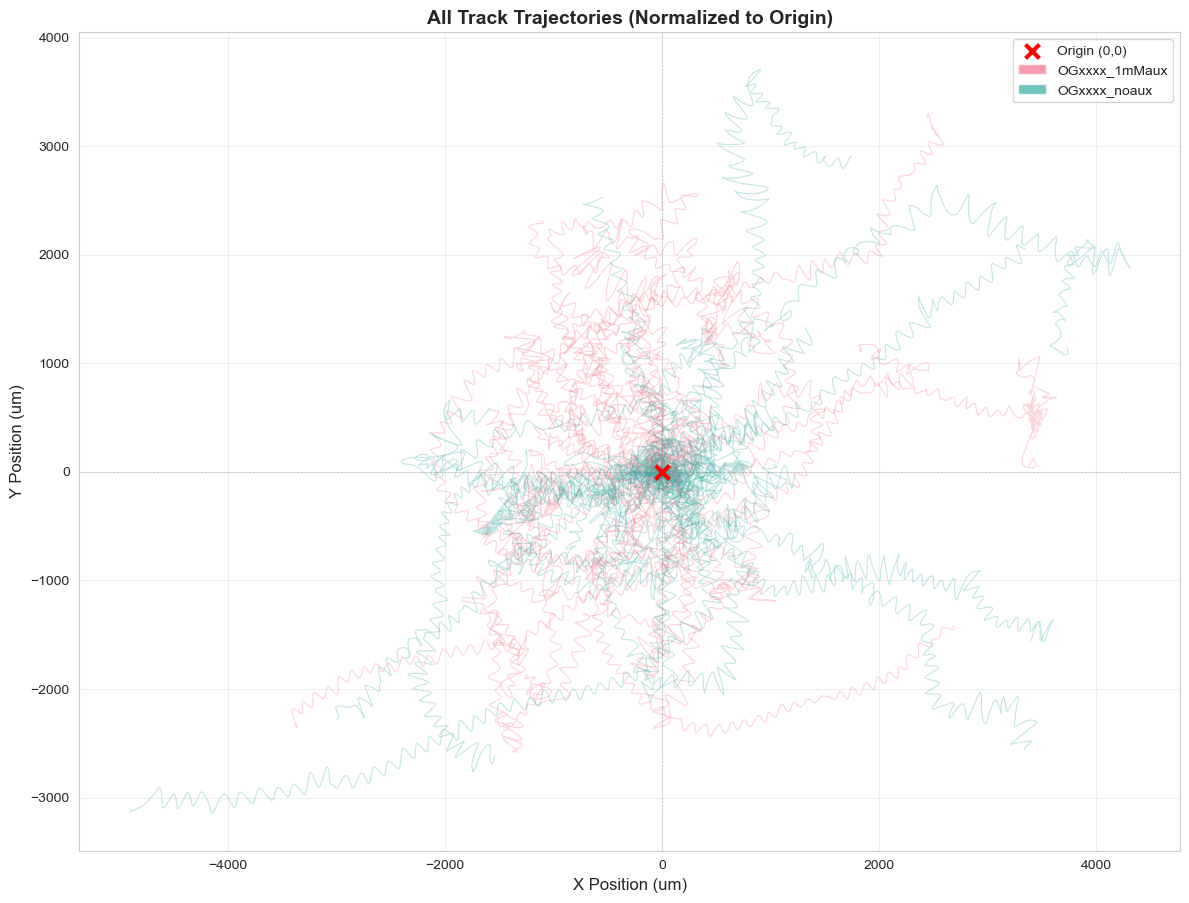

Track trajectories plot saved!


In [64]:
# Create a color palette for strain/genotype groups
if not genotypes:
    genotypes = sorted(df_tracks['strain_genotype'].astype(str).unique())
colors = sns.color_palette('husl', n_colors=len(genotypes))
color_map = dict(zip(genotypes, colors))

# Plot all tracks on one graph
fig, ax = plt.subplots(figsize=(12, 10))

for track_id in df_tracks['track_id'].unique():
    track_data = df_tracks[df_tracks['track_id'] == track_id]
    label = str(track_data['strain_genotype'].iloc[0])
    
    ax.plot(track_data['X'], track_data['Y'], 
            color=color_map[label], alpha=0.3, linewidth=0.8)

# Mark origin
ax.scatter([0], [0], color='red', s=100, marker='x', linewidths=3, 
           label='Origin (0,0)', zorder=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[g], label=g, alpha=0.7) 
                   for g in genotypes]
legend_elements.insert(0, ax.get_legend_handles_labels()[0][0])
ax.legend(handles=legend_elements, loc='best', frameon=True, fontsize=10)

ax.set_xlabel('X Position (um)', fontsize=12)
ax.set_ylabel('Y Position (um)', fontsize=12)
ax.set_title('All Track Trajectories (Normalized to Origin)', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'track_trajectories_all.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'track_trajectories_all.pdf', bbox_inches='tight')
plt.show()

print("Track trajectories plot saved!")

## 8. Plot 3: Track Trajectories by Genotype (Separate Panels)

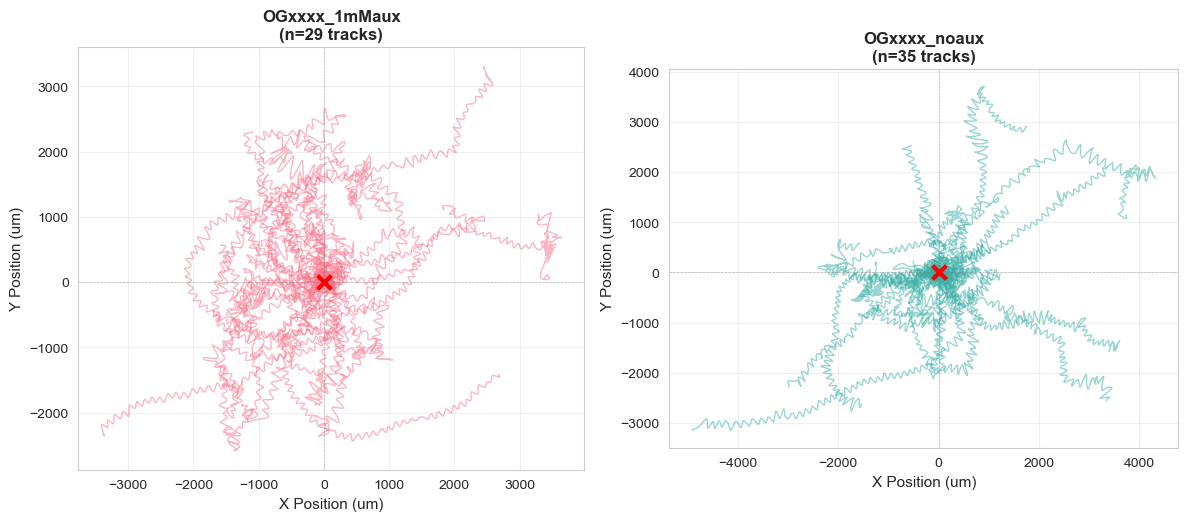

Track trajectories by genotype saved!


In [65]:
# Separate subplots for each strain/genotype group
n_genotypes = len(genotypes)
n_cols = min(3, n_genotypes)
n_rows = int(np.ceil(n_genotypes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
if n_genotypes == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, label in enumerate(genotypes):
    ax = axes[idx]
    
    # Get tracks for this group
    genotype_tracks = df_tracks[df_tracks['strain_genotype'] == label]
    
    for track_id in genotype_tracks['track_id'].unique():
        track_data = genotype_tracks[genotype_tracks['track_id'] == track_id]
        ax.plot(track_data['X'], track_data['Y'], 
                color=color_map[label], alpha=0.5, linewidth=1)
    
    # Mark origin
    ax.scatter([0], [0], color='red', s=100, marker='x', linewidths=3, zorder=10)
    
    ax.set_xlabel('X Position (um)', fontsize=11)
    ax.set_ylabel('Y Position (um)', fontsize=11)
    ax.set_title(f'{label}\n(n={len(genotype_tracks["track_id"].unique())} tracks)', 
                 fontsize=12, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_genotypes, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'track_trajectories_by_genotype.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'track_trajectories_by_genotype.pdf', bbox_inches='tight')
plt.show()

print("Track trajectories by genotype saved!")

## 9. Analysis 2: Movement Metrics (Straightness Index)

In [66]:
# Calculate group statistics for straightness
straightness_stats = calculate_group_stats(df_metrics, 'strain_genotype', 'straightness')
print("=== Straightness Index by Strain/Genotype ===")
print(straightness_stats)

# Statistical tests
pairwise_straightness = perform_pairwise_tests(df_metrics, 'strain_genotype', 'straightness', test='ttest')
print("\n=== Pairwise Comparisons (Straightness) ===")
print(pairwise_straightness)

# Save results
straightness_stats.to_csv(RESULTS_DIR / 'straightness_group_summary.csv', index=False)
pairwise_straightness.to_csv(RESULTS_DIR / 'straightness_pairwise_tests.csv', index=False)

=== Straightness Index by Strain/Genotype ===
  strain_genotype      mean       std   n       sem
0   OGxxxx_1mMaux  0.191471  0.174029  29  0.032316
1    OGxxxx_noaux  0.177663  0.171799  35  0.029039

=== Pairwise Comparisons (Straightness) ===
          group1        group2    test  statistic   p_value significant
0  OGxxxx_1mMaux  OGxxxx_noaux  t-test   0.318196  0.751405          No


## 10. Plot 4: Straightness Index

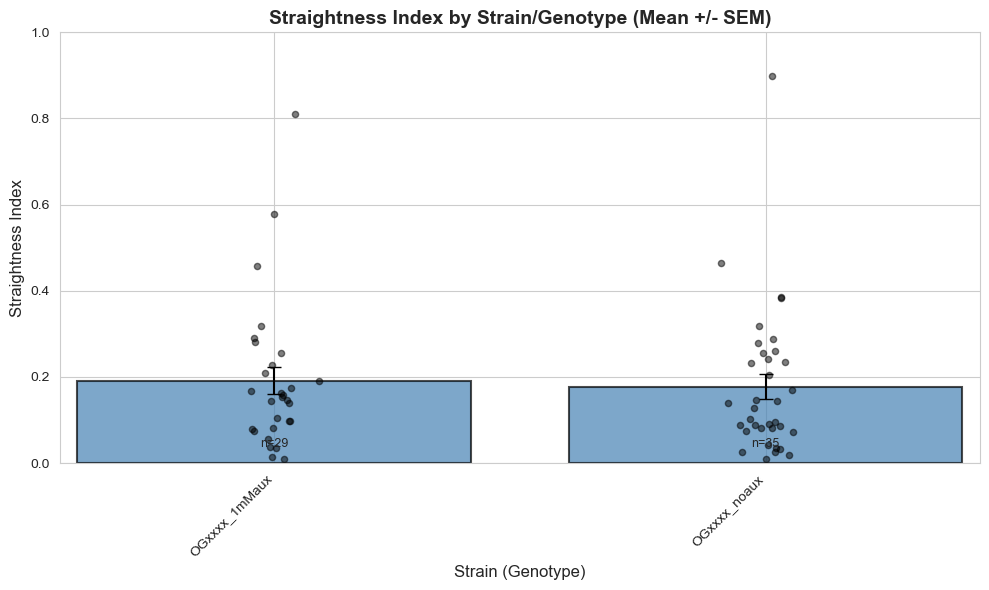

Straightness index plot saved!


In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with error bars
x_pos = np.arange(len(straightness_stats))
ax.bar(x_pos, straightness_stats['mean'], yerr=straightness_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5, color='steelblue')

# Overlay individual points
for i, label in enumerate(straightness_stats['strain_genotype']):
    data = df_metrics[df_metrics['strain_genotype'] == label]['straightness'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.5, color='black', s=20)

ax.set_xticks(x_pos)
ax.set_xticklabels(straightness_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Straightness Index', fontsize=12)
ax.set_xlabel('Strain (Genotype)', fontsize=12)
ax.set_title('Straightness Index by Strain/Genotype (Mean +/- SEM)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.margins(x=0.02)

# Add sample sizes inside plot area
y_min, y_max = ax.get_ylim()
y_text = y_min + 0.03 * (y_max - y_min)
for i, (label, n) in enumerate(zip(straightness_stats['strain_genotype'], straightness_stats['n'])):
    ax.text(i, y_text, f'n={int(n)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'straightness_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'straightness_comparison.pdf', bbox_inches='tight')
plt.show()

print("Straightness index plot saved!")

## 11. Analysis 3: Fatigue Index

In [68]:
# Calculate group statistics for fatigue
fatigue_stats = calculate_group_stats(df_metrics, 'strain_genotype', 'fatigue_index')
print("=== Fatigue Index by Strain/Genotype ===")
print(fatigue_stats)
print("\nNote: Fatigue index < 1 indicates slowing down over time")

# Statistical tests
pairwise_fatigue = perform_pairwise_tests(df_metrics, 'strain_genotype', 'fatigue_index', test='ttest')
print("\n=== Pairwise Comparisons (Fatigue) ===")
print(pairwise_fatigue)

# Save results
fatigue_stats.to_csv(RESULTS_DIR / 'fatigue_group_summary.csv', index=False)
pairwise_fatigue.to_csv(RESULTS_DIR / 'fatigue_pairwise_tests.csv', index=False)

=== Fatigue Index by Strain/Genotype ===
  strain_genotype      mean       std   n       sem
0   OGxxxx_1mMaux  1.044339  0.274158  25  0.054832
1    OGxxxx_noaux  0.977340  0.212718  29  0.039501

Note: Fatigue index < 1 indicates slowing down over time

=== Pairwise Comparisons (Fatigue) ===
          group1        group2    test  statistic   p_value significant
0  OGxxxx_1mMaux  OGxxxx_noaux  t-test   1.010208  0.317073          No


## 12. Plot 5: Fatigue Index

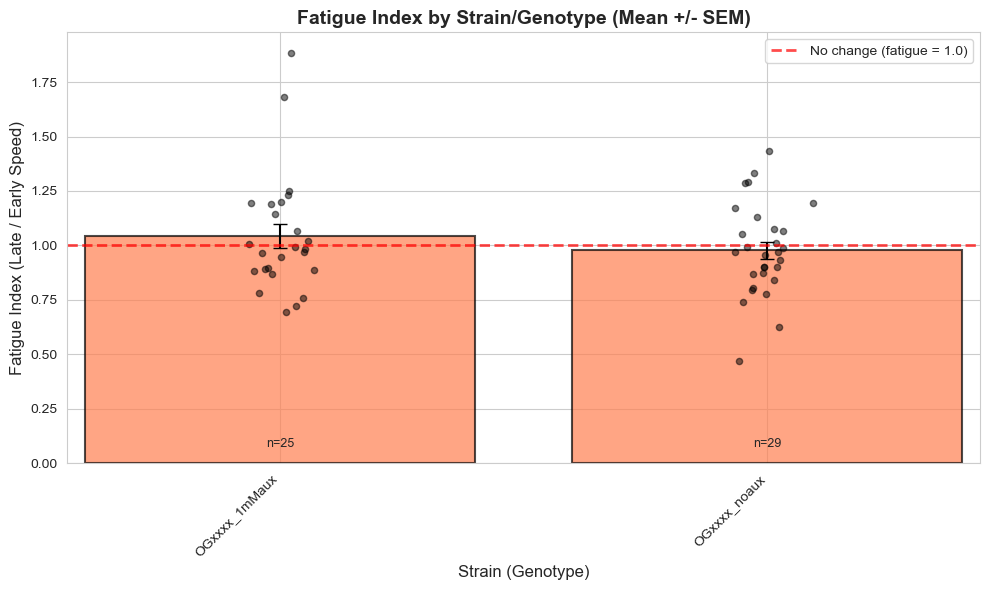

Fatigue index plot saved!


In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with error bars
x_pos = np.arange(len(fatigue_stats))
ax.bar(x_pos, fatigue_stats['mean'], yerr=fatigue_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5, color='coral')

# Overlay individual points
for i, label in enumerate(fatigue_stats['strain_genotype']):
    data = df_metrics[df_metrics['strain_genotype'] == label]['fatigue_index'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.5, color='black', s=20)

# Add reference line at 1.0
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, 
           label='No change (fatigue = 1.0)', alpha=0.7)

ax.set_xticks(x_pos)
ax.set_xticklabels(fatigue_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Fatigue Index (Late / Early Speed)', fontsize=12)
ax.set_xlabel('Strain (Genotype)', fontsize=12)
ax.set_title('Fatigue Index by Strain/Genotype (Mean +/- SEM)', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.margins(x=0.02)

# Add sample sizes inside plot area
y_min, y_max = ax.get_ylim()
y_text = y_min + 0.03 * (y_max - y_min)
for i, (label, n) in enumerate(zip(fatigue_stats['strain_genotype'], fatigue_stats['n'])):
    ax.text(i, y_text, f'n={int(n)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fatigue_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fatigue_comparison.pdf', bbox_inches='tight')
plt.show()

print("Fatigue index plot saved!")

## 13. Analysis 4: Thrashing Frequency

In [70]:
# Calculate group statistics for thrashing
thrashing_stats = calculate_group_stats(df_thrashing, 'strain_genotype', 'thrashing_frequency_hz')
print("=== Thrashing Frequency by Strain/Genotype ===")
print(thrashing_stats)

# Statistical tests
pairwise_thrashing = perform_pairwise_tests(df_thrashing, 'strain_genotype', 'thrashing_frequency_hz', test='ttest')
print("\n=== Pairwise Comparisons (Thrashing) ===")
print(pairwise_thrashing)

# Save results
thrashing_stats.to_csv(RESULTS_DIR / 'thrashing_group_summary.csv', index=False)
pairwise_thrashing.to_csv(RESULTS_DIR / 'thrashing_pairwise_tests.csv', index=False)

=== Thrashing Frequency by Strain/Genotype ===
  strain_genotype      mean       std   n       sem
0   OGxxxx_1mMaux  1.793893  0.395501  29  0.073443
1    OGxxxx_noaux  1.688285  0.399719  34  0.068551

=== Pairwise Comparisons (Thrashing) ===
          group1        group2    test  statistic   p_value significant
0  OGxxxx_1mMaux  OGxxxx_noaux  t-test   1.050304  0.297722          No


## 14. Plot 6: Thrashing Frequency

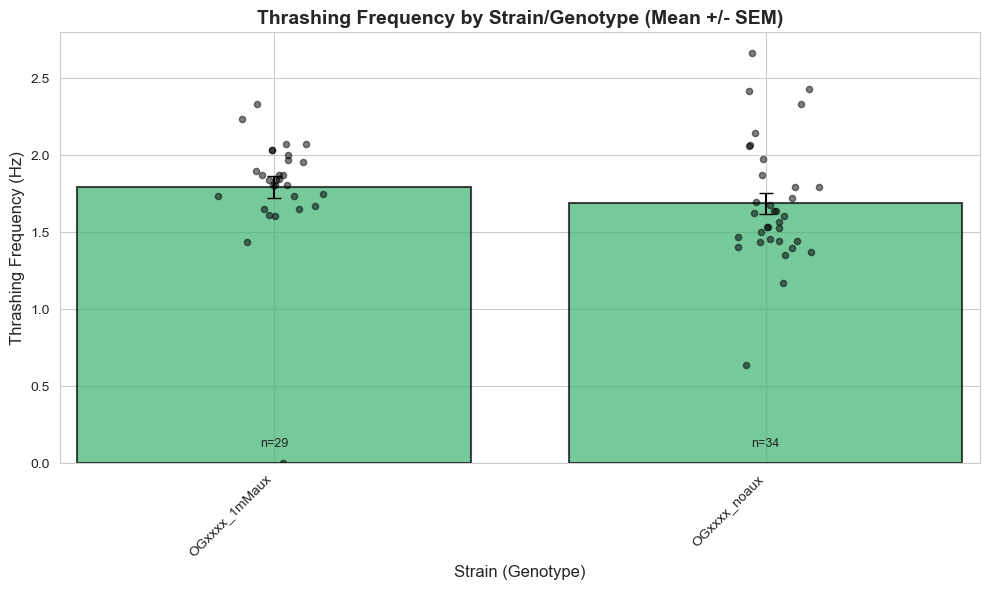

Thrashing frequency plot saved!


In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with error bars
x_pos = np.arange(len(thrashing_stats))
ax.bar(x_pos, thrashing_stats['mean'], yerr=thrashing_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5, color='mediumseagreen')

# Overlay individual points
for i, label in enumerate(thrashing_stats['strain_genotype']):
    data = df_thrashing[df_thrashing['strain_genotype'] == label]['thrashing_frequency_hz'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.5, color='black', s=20)

ax.set_xticks(x_pos)
ax.set_xticklabels(thrashing_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Thrashing Frequency (Hz)', fontsize=12)
ax.set_xlabel('Strain (Genotype)', fontsize=12)
ax.set_title('Thrashing Frequency by Strain/Genotype (Mean +/- SEM)', fontsize=14, fontweight='bold')
ax.margins(x=0.02)
ax.set_ylim(bottom=0)

# Add sample sizes inside plot area
y_min, y_max = ax.get_ylim()
y_text = y_min + 0.03 * (y_max - y_min)
for i, (label, n) in enumerate(zip(thrashing_stats['strain_genotype'], thrashing_stats['n'])):
    ax.text(i, y_text, f'n={int(n)}', ha='center', va='bottom', fontsize=9)

# Add p-value annotations for specific comparisons
label_to_x = {str(label): idx for idx, label in enumerate(thrashing_stats['strain_genotype'])}
pairwise_thrashing['group1'] = pairwise_thrashing['group1'].astype(str)
pairwise_thrashing['group2'] = pairwise_thrashing['group2'].astype(str)
label_rk202 = label_by_genotype.get('RK202')
label_rk204 = label_by_genotype.get('RK204')
label_rk203 = label_by_genotype.get('RK203')
label_rk205 = label_by_genotype.get('RK205')
comparisons = [
    (label_rk202, label_rk204),
    (label_rk203, label_rk205),
]
comparisons = [c for c in comparisons if c[0] in label_to_x and c[1] in label_to_x]

if comparisons:
    y_base = max((thrashing_stats['mean'] + thrashing_stats['sem']).max(), y_max)
    y_step = 0.08 * y_base
    for idx, (label_a, label_b) in enumerate(comparisons):
        mask = ((pairwise_thrashing['group1'] == label_a) & (pairwise_thrashing['group2'] == label_b)) | (
            (pairwise_thrashing['group1'] == label_b) & (pairwise_thrashing['group2'] == label_a)
        )
        if not pairwise_thrashing[mask].empty:
            p_value = float(pairwise_thrashing[mask]['p_value'].iloc[0])
            x1 = label_to_x[label_a]
            x2 = label_to_x[label_b]
            y = y_base + idx * y_step
            h = y_step * 0.3
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y + h, f'p={p_value:.3g}', ha='center', va='bottom', fontsize=9)
    ax.set_ylim(top=y_base + y_step * (len(comparisons) + 1))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'thrashing_frequency_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'thrashing_frequency_comparison.pdf', bbox_inches='tight')
plt.show()

print("Thrashing frequency plot saved!")

## 15. Plot 7: Sample Curvature vs Time (Peaks)

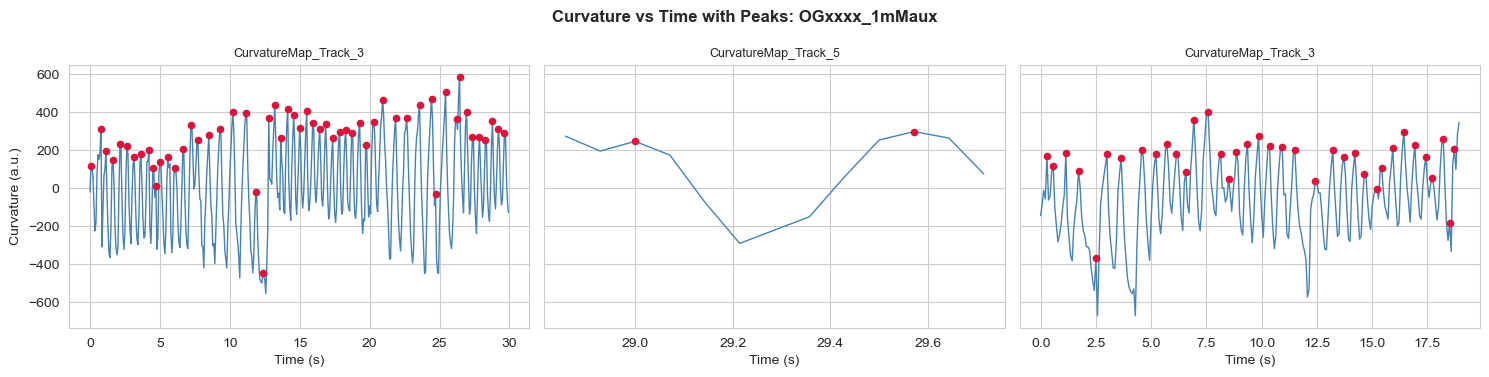

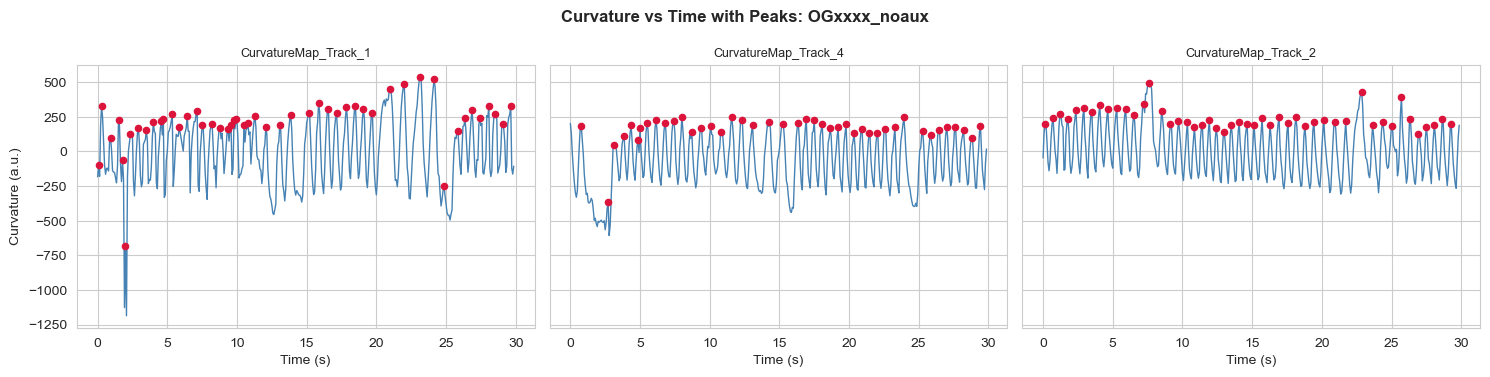

In [74]:
# Plot 3 sample curvature traces per genotype with peaks
rng = np.random.default_rng(0)
curvature_files = [p for p in RAW_DATA_DIR.glob('**/CurvatureMap*Track_*.csv') if p.is_file() and p.stat().st_size > 0]
curvature_by_genotype = {}
for file_path in curvature_files:
    genotype_dir = file_path.parents[1].name
    curvature_by_genotype.setdefault(genotype_dir, []).append(file_path)

def load_curvature_series(curvature_path):
    try:
        df = pd.read_csv(curvature_path, skiprows=1)
    except pd.errors.EmptyDataError:
        return None, None
    curvature_columns = [col for col in df.columns if col not in ['Frame', 'Time']]
    if not curvature_columns:
        return None, None
    midbody_col = curvature_columns[len(curvature_columns) // 2]
    curvature = df[midbody_col].dropna()
    time = df['Time'].loc[curvature.index]
    return time, curvature

# Use genotypes list (already ordered by labels)
plot_labels = genotypes if genotypes else sorted(df_metrics['strain_genotype'].astype(str).unique())
label_to_folder = {v: k for k, v in label_by_genotype.items()}

for label in plot_labels:
    genotype_dir = label_to_folder.get(str(label), None)
    if genotype_dir is None:
        continue
    if genotype_dir not in curvature_by_genotype:
        continue
    files = sorted(curvature_by_genotype[genotype_dir])
    if len(files) == 0:
        continue
    sample_files = files[:3] if len(files) <= 3 else rng.choice(files, size=3, replace=False)
    n_cols = len(sample_files)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 3.8), sharey=True)
    if n_cols == 1:
        axes = [axes]
    for ax, file_path in zip(axes, sample_files):
        time, curvature = load_curvature_series(file_path)
        if time is None or curvature is None or len(curvature) < 10:
            ax.set_title(f'{file_path.name}\n(no data)', fontsize=10)
            ax.axis('off')
            continue
        peaks, _ = find_peaks(curvature, prominence=50)
        ax.plot(time, curvature, color='steelblue', linewidth=1)
        ax.scatter(time.iloc[peaks], curvature.iloc[peaks], color='crimson', s=20, zorder=3)
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_title(file_path.stem, fontsize=9)
    axes[0].set_ylabel('Curvature (a.u.)', fontsize=10)
    plt.suptitle(f'Curvature vs Time with Peaks: {label}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 16. Multi-Panel Summary Figure

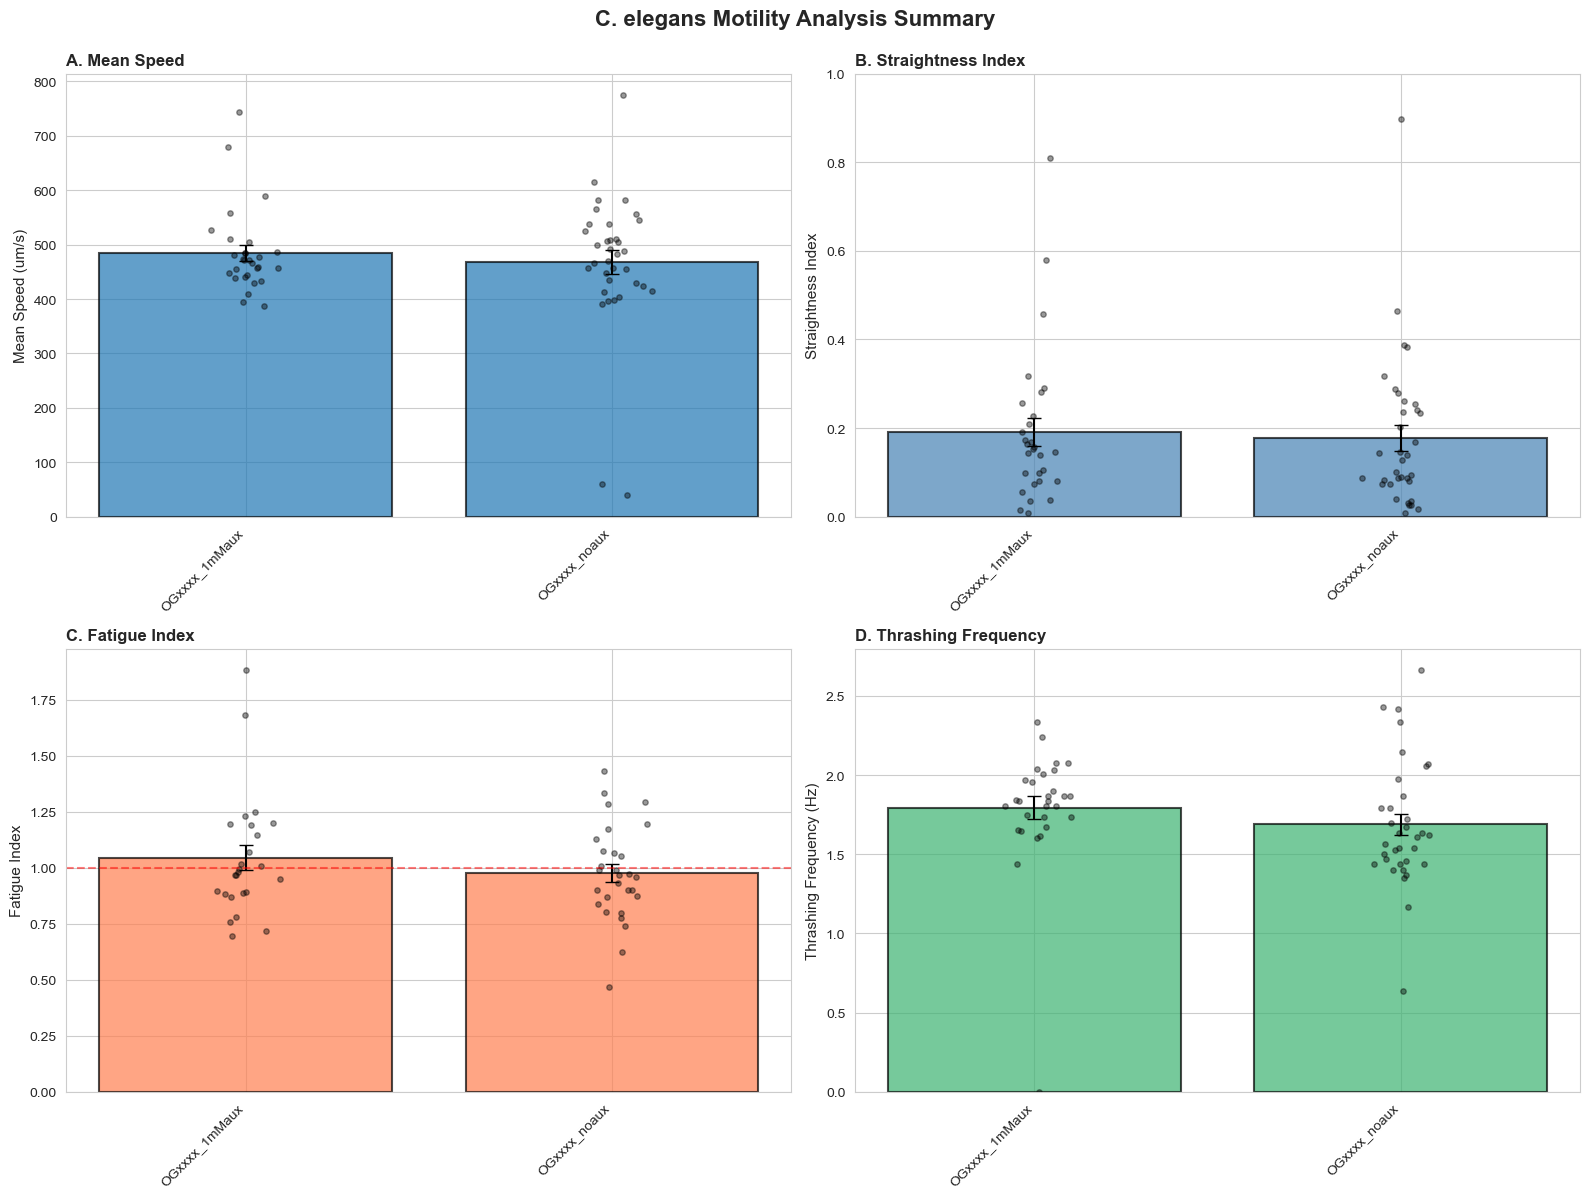

Summary figure saved!


In [ ]:
# Create a comprehensive 4-panel summary figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

def annotate_pairwise(ax, stats_df, pairwise_df, label_by_genotype, genotype_pairs):
    label_to_x = {str(label): idx for idx, label in enumerate(stats_df['strain_genotype'])}
    pairwise_df['group1'] = pairwise_df['group1'].astype(str)
    pairwise_df['group2'] = pairwise_df['group2'].astype(str)
    comparisons = []
    for left, right in genotype_pairs:
        label_left = label_by_genotype.get(left)
        label_right = label_by_genotype.get(right)
        if label_left in label_to_x and label_right in label_to_x:
            comparisons.append((label_left, label_right))
    if not comparisons:
        return
    y_min, y_max = ax.get_ylim()
    y_base = max((stats_df['mean'] + stats_df['sem']).max(), y_max)
    y_step = 0.08 * y_base
    for idx, (label_a, label_b) in enumerate(comparisons):
        mask = ((pairwise_df['group1'] == label_a) & (pairwise_df['group2'] == label_b)) | (
            (pairwise_df['group1'] == label_b) & (pairwise_df['group2'] == label_a)
        )
        if not pairwise_df[mask].empty:
            p_value = float(pairwise_df[mask]['p_value'].iloc[0])
            x1 = label_to_x[label_a]
            x2 = label_to_x[label_b]
            y = y_base + idx * y_step
            h = y_step * 0.3
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y + h, f'p={p_value:.3g}', ha='center', va='bottom', fontsize=9)
    ax.set_ylim(top=y_base + y_step * (len(comparisons) + 1))

genotype_pairs = [('OGxxxx_1mMaux', 'OGxxxx_noaux')]

# Panel A: Speed
ax = axes[0]
x_pos = np.arange(len(speed_stats))
ax.bar(x_pos, speed_stats['mean'], yerr=speed_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5)
for i, label in enumerate(speed_stats['strain_genotype']):
    data = df_metrics[df_metrics['strain_genotype'] == label]['mean_speed'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.4, color='black', s=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(speed_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Mean Speed (um/s)', fontsize=11)
ax.set_title('A. Mean Speed', fontsize=12, fontweight='bold', loc='left')
annotate_pairwise(ax, speed_stats, pairwise_speed, label_by_genotype, genotype_pairs)

# Panel B: Straightness
ax = axes[1]
x_pos = np.arange(len(straightness_stats))
ax.bar(x_pos, straightness_stats['mean'], yerr=straightness_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5, color='steelblue')
for i, label in enumerate(straightness_stats['strain_genotype']):
    data = df_metrics[df_metrics['strain_genotype'] == label]['straightness'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.4, color='black', s=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(straightness_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Straightness Index', fontsize=11)
ax.set_title('B. Straightness Index', fontsize=12, fontweight='bold', loc='left')
ax.set_ylim(0, 1)
annotate_pairwise(ax, straightness_stats, pairwise_straightness, label_by_genotype, genotype_pairs)

# Panel C: Fatigue
ax = axes[2]
x_pos = np.arange(len(fatigue_stats))
ax.bar(x_pos, fatigue_stats['mean'], yerr=fatigue_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5, color='coral')
for i, label in enumerate(fatigue_stats['strain_genotype']):
    data = df_metrics[df_metrics['strain_genotype'] == label]['fatigue_index'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.4, color='black', s=15)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(fatigue_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Fatigue Index', fontsize=11)
ax.set_title('C. Fatigue Index', fontsize=12, fontweight='bold', loc='left')
annotate_pairwise(ax, fatigue_stats, pairwise_fatigue, label_by_genotype, genotype_pairs)

# Panel D: Thrashing
ax = axes[3]
x_pos = np.arange(len(thrashing_stats))
ax.bar(x_pos, thrashing_stats['mean'], yerr=thrashing_stats['sem'], 
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5, color='mediumseagreen')
for i, label in enumerate(thrashing_stats['strain_genotype']):
    data = df_thrashing[df_thrashing['strain_genotype'] == label]['thrashing_frequency_hz'].dropna()
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x_jitter, data, alpha=0.4, color='black', s=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(thrashing_stats['strain_genotype'], rotation=45, ha='right')
ax.set_ylabel('Thrashing Frequency (Hz)', fontsize=11)
ax.set_title('D. Thrashing Frequency', fontsize=12, fontweight='bold', loc='left')
annotate_pairwise(ax, thrashing_stats, pairwise_thrashing, label_by_genotype, genotype_pairs)

plt.suptitle('C. elegans Motility Analysis Summary', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'summary_figure.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'summary_figure.pdf', bbox_inches='tight')
plt.show()

print("Summary figure saved!")

## 17. Save Statistical Summary

In [76]:
# Compile all statistics into a summary report
stats_summary = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_tracks_analyzed': len(df_metrics),
    'genotypes': genotypes,
    'speed_anova': {
        'f_statistic': float(f_stat) if f_stat is not None else None,
        'p_value': float(p_value) if p_value is not None else None
    },
    'group_summaries': {
        'speed': speed_stats.to_dict('records'),
        'straightness': straightness_stats.to_dict('records'),
        'fatigue': fatigue_stats.to_dict('records'),
        'thrashing': thrashing_stats.to_dict('records')
    }
}

# Save as JSON
with open(RESULTS_DIR / 'stats_summary.json', 'w') as f:
    json.dump(stats_summary, f, indent=2)

print("Statistical summary saved to stats_summary.json")
print("\n✓ DATA ANALYSIS AND PLOTTING COMPLETE!")

Statistical summary saved to stats_summary.json

✓ DATA ANALYSIS AND PLOTTING COMPLETE!
